In [1]:
### SPUSTIT TOHLE NA PC PŘED PRACÍ !!

import os
import sys
import pydicom # type: ignore
import matplotlib.pyplot as plt # type: ignore
import pandas as pd # type: ignore
from glob import glob
from codes.custom_library import Graf_1_2

# Set the working directory to the project directory
device = input("Zadej prosím, na jakém zařízení děláš (mac/doma/prace): ")
if device == "doma":
    project_dir = r"C:/Users/danie/Desktop/mrtva_doba_VU"
    os.chdir(project_dir)
elif device == "mac":
    project_dir = r"/Users/danielptacek/Desktop/mrtva_doba_VU"
    os.chdir(project_dir)
else:
    project_dir = r"U:/Dokumenty/mrtva_doba_VU"
    os.chdir(project_dir)


# Verify the change
print("Current working directory:", os.getcwd()) 

# Ensure the project directory is in sys.path
if project_dir not in sys.path:
    sys.path.append(project_dir)

aktivity = {
    "20240708" : 700.589,
    "20240709" : 640.979,
    "20240710" : 586.294,
    "20240711" : 537.692,
    "20240712" : 495.958,
    "20240714" : 404.370,
    "20240715" : 379.365,
    "20240717" : 324.319,
    "20240719" : 266.596,
    "20240721" : 226.576,
    "20240723" : 190.942,
    "20240725" : 158.536,
    "20240726" : 152.496,
    "20240729" : 115.038,
    "20240731" : 93.633,
    "20240805" : 62.613,
    "20240808" : 49.233,
    "20240812" : 34.167,
    "20240815" : 26.602,
    "20240819" : 18.401,
    "20240822" : 14.270,
    "20240826" : 10.122,
    "20240903" : 5.069,
    "20240912" : 2.363
}

Current working directory: C:\Users\danie\Desktop\mrtva_doba_VU


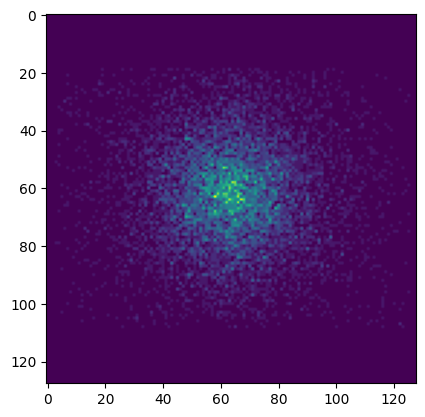

In [14]:
#### planarni kalibrace Optima


from dicom_file_separator import separate_dicom_file, separate_dicom_file_tomo
from tew_correction import tew_correction
from codes.custom_library import region_growing
from geom_prumer import geom_prumer
import numpy as np
from glob import glob

# kalibrace_folder = "KALIBRACE_20240815/Kalibrace_tomo_20240815_Optima"
# kalibrace_mds = sorted(glob(os.path.join(kalibrace_folder, 'Kalibrace*')))

kal_obraz_path = "KALIBRACE_20240815/Kalibrace_tomo_20240815_Optima/Kalibrace_tomo_1_20240815_Optima.dcm"







In [ ]:
#### planarni kalibrace Optima


from dicom_file_separator import separate_dicom_file
from tew_correction import tew_correction
from codes.custom_library import region_growing
from geom_prumer import geom_prumer
import numpy as np
from glob import glob

kalibrace_folder = "KALIBRACE_20240815/Kalibrace_tomo_20240815_Optima"
kalibrace_mds = sorted(glob(os.path.join(kalibrace_folder, 'Kalibrace*')))

prah = 0.1

hlava_1_kal_faktory = []
hlava_1_tew_kal_faktory = []
hlava_2_kal_faktory = []
hlava_2_tew_kal_faktory = []
hlavy_gm = []
hlavy_gm_tew = []


for md in kalibrace_mds:
    image = separate_dicom_file(md)

    acq_time = image["Acq_time"]
    acq_date = image["Acq_date"]

    hlava_1 = image["Head1_EM"]
    hlava_1_tew = tew_correction(image["Head1_EM"], image["Head1_SC1"], image["Head1_SC2"])
    hlava_2 = image["Head2_EM"]
    hlava_2_tew = tew_correction(image["Head2_EM"], image["Head2_SC1"], image["Head2_SC2"])

    maska_1 = region_growing(hlava_1, prah*np.max(hlava_1))
    maska_1_tew = region_growing(hlava_1_tew, prah*np.max(hlava_1_tew))
    maska_2 = region_growing(hlava_2, prah*np.max(hlava_2))
    maska_2_tew = region_growing(hlava_2_tew, prah*np.max(hlava_2_tew))


    kal_faktor_1 = (np.sum(hlava_1*maska_1) / acq_time) / aktivity[acq_date]
    kal_faktor_1_tew = (np.sum(hlava_1_tew*maska_1_tew) / acq_time) / aktivity[acq_date]
    kal_faktor_2 = (np.sum(hlava_2*maska_2) / acq_time) / aktivity[acq_date]
    kal_faktor_2_tew = (np.sum(hlava_2_tew*maska_2_tew) / acq_time) / aktivity[acq_date]
    kal_faktor_gm = (geom_prumer(np.sum(hlava_1*maska_1), np.sum(hlava_2*maska_2)) / acq_time) / aktivity[acq_date]
    kal_faktor_gm_tew = (geom_prumer(np.sum(hlava_1_tew*maska_1_tew), np.sum(hlava_2_tew*maska_2_tew)) / acq_time) / aktivity[acq_date]


    hlava_1_kal_faktory.append(kal_faktor_1)
    hlava_1_tew_kal_faktory.append(kal_faktor_1_tew)
    hlava_2_kal_faktory.append(kal_faktor_2)
    hlava_2_tew_kal_faktory.append(kal_faktor_2_tew)
    hlavy_gm.append(kal_faktor_gm)
    hlavy_gm_tew.append(kal_faktor_gm_tew)

print(f"Anterior: {np.mean(hlava_1_kal_faktory)} +- {np.std(hlava_1_kal_faktory, ddof=1)}")
print(f"Anterior TEW: {np.mean(hlava_1_tew_kal_faktory)} +- {np.std(hlava_1_tew_kal_faktory, ddof=1)}")
print(f"Posterior: {np.mean(hlava_2_kal_faktory)} +- {np.std(hlava_2_kal_faktory, ddof=1)}")
print(f"Posterior TEW: {np.mean(hlava_2_tew_kal_faktory)} +- {np.std(hlava_2_tew_kal_faktory, ddof=1)}")
print(f"Geom. Mean: {np.mean(hlavy_gm)} +- {np.std(hlavy_gm, ddof=1)}")
print(f"Geom. Mean TEW: {np.mean(hlavy_gm_tew)} +- {np.std(hlavy_gm_tew, ddof=1)}")

In [21]:
#### planarni kalibrace Discovery


from dicom_file_separator import separate_dicom_file
from tew_correction import tew_correction
from codes.custom_library import region_growing
from geom_prumer import geom_prumer
import numpy as np
from glob import glob

kalibrace_folder = "KALIBRACE_20240815/Kalibrace_tomo_20240815_Discovery"
kalibrace_mds = sorted(glob(os.path.join(kalibrace_folder, 'Kalibrace*')))

prah = 0.1

hlava_1_kal_faktory = []
hlava_1_tew_kal_faktory = []
hlava_2_kal_faktory = []
hlava_2_tew_kal_faktory = []
hlavy_gm = []
hlavy_gm_tew = []


for md in kalibrace_mds:
    image = separate_dicom_file(md)

    acq_time = image["Acq_time"]
    acq_date = image["Acq_date"]

    hlava_1 = image["Head1_EM"]
    hlava_1_tew = tew_correction(image["Head1_EM"], image["Head1_SC1"], image["Head1_SC2"])
    hlava_2 = image["Head2_EM"]
    hlava_2_tew = tew_correction(image["Head2_EM"], image["Head2_SC1"], image["Head2_SC2"])

    maska_1 = region_growing(hlava_1, prah*np.max(hlava_1))
    maska_1_tew = region_growing(hlava_1_tew, prah*np.max(hlava_1_tew))
    maska_2 = region_growing(hlava_2, prah*np.max(hlava_2))
    maska_2_tew = region_growing(hlava_2_tew, prah*np.max(hlava_2_tew))


    kal_faktor_1 = (np.sum(hlava_1*maska_1) / acq_time) / aktivity[acq_date]
    kal_faktor_1_tew = (np.sum(hlava_1_tew*maska_1_tew) / acq_time) / aktivity[acq_date]
    kal_faktor_2 = (np.sum(hlava_2*maska_2) / acq_time) / aktivity[acq_date]
    kal_faktor_2_tew = (np.sum(hlava_2_tew*maska_2_tew) / acq_time) / aktivity[acq_date]
    kal_faktor_gm = (geom_prumer(np.sum(hlava_1*maska_1), np.sum(hlava_2*maska_2)) / acq_time) / aktivity[acq_date]
    kal_faktor_gm_tew = (geom_prumer(np.sum(hlava_1_tew*maska_1_tew), np.sum(hlava_2_tew*maska_2_tew)) / acq_time) / aktivity[acq_date]


    hlava_1_kal_faktory.append(kal_faktor_1)
    hlava_1_tew_kal_faktory.append(kal_faktor_1_tew)
    hlava_2_kal_faktory.append(kal_faktor_2)
    hlava_2_tew_kal_faktory.append(kal_faktor_2_tew)
    hlavy_gm.append(kal_faktor_gm)
    hlavy_gm_tew.append(kal_faktor_gm_tew)

print(f"Anterior: {np.mean(hlava_1_kal_faktory)} +- {np.std(hlava_1_kal_faktory, ddof=1)}")
print(f"Anterior TEW: {np.mean(hlava_1_tew_kal_faktory)} +- {np.std(hlava_1_tew_kal_faktory, ddof=1)}")
print(f"Posterior: {np.mean(hlava_2_kal_faktory)} +- {np.std(hlava_2_kal_faktory, ddof=1)}")
print(f"Posterior TEW: {np.mean(hlava_2_tew_kal_faktory)} +- {np.std(hlava_2_tew_kal_faktory, ddof=1)}")
print(f"Geom. Mean: {np.mean(hlavy_gm)} +- {np.std(hlavy_gm, ddof=1)}")
print(f"Geom. Mean TEW: {np.mean(hlavy_gm_tew)} +- {np.std(hlavy_gm_tew, ddof=1)}")

Anterior: 24.45827939530902 +- 0.11954275791842256
Anterior TEW: 18.875387017177665 +- 0.035376527133632395
Posterior: 8.589710806397132 +- 0.15095895906799414
Posterior TEW: 6.039889669721122 +- 0.023021265125908328
Geom. Mean: 14.494066117422 +- 0.1428101033878588
Geom. Mean TEW: 10.67729931174871 +- 0.01896807631177647
